In [2]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor

import os


In [3]:
def load_abstain(dataset, model_type, noise_type, epsilon=0.1, fixed_class = 0, fixed_noise = 0.0):
    path = "/scratch/hdd001/home/snagaraj/results/abstain/"
    
    if noise_type == "class_independent":
        file_path = os.path.join(path, dataset, model_type, noise_type ,f"{epsilon}.pkl")
    elif noise_type == "class_conditional":
        file_path = os.path.join(path, dataset, model_type, noise_type ,f"{epsilon}.pkl")
    
    with open(file_path, 'rb') as file:
            # Use pickle to write the dictionary to the file
            data = pkl.load(file)
            
    return data
    

In [12]:
regrets = []
coverages = []
thresholds = []
noise_levels = []
disagreement_tests = {}
iterations = []
losses = []
datasets = []

noise_type = "class_independent"
model_type = "LR"

for dataset in ["cshock_eicu", "cshock_mimic", "saps", "support", "lungcancer"]:

    X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

  

    data = load_abstain(dataset, model_type, noise_type)

    df = pd.DataFrame(data)



    for noise_level in df.noise.unique():
        for loss in df.loss.unique():
            sub_df = df[(df["loss"] == loss) & (df["noise"]==noise_level)]

            dis = sub_df.disagreement_test.values[0]
            preds = (sub_df.test_preds.values[0]>0.5).astype(int)

            for threshold in np.linspace(0,101,100): ##

                abstain_test = abstain(dis, threshold)

                regret = 100*np.mean(abs(preds-y_test)*(1-abstain_test))
                coverage = 100*np.mean(1-abstain_test)

                regrets.append(regret)
                coverages.append(coverage)
                thresholds.append(threshold)
                noise_levels.append(noise_level)
                losses.append(loss)
                datasets.append(dataset)



            # Create a DataFrame from the arrays
data = pd.DataFrame({'Regret': regrets, 'Coverage': coverages, 'Noise Level': noise_levels, "Threshold":thresholds, "Loss":losses, "Dataset":datasets})

    #path = os.path.join(files_path, f"{epsilon}.pkl")

        # Open a file for writing

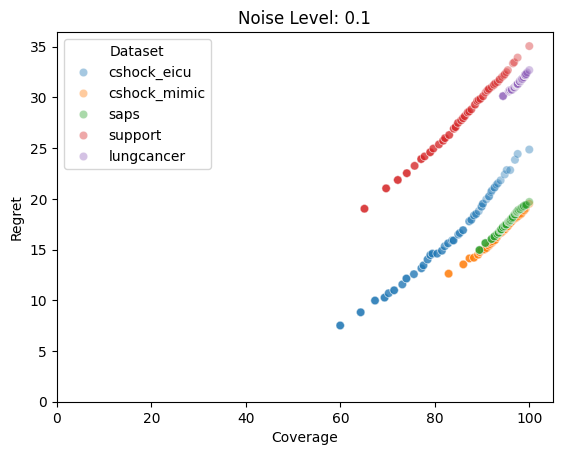

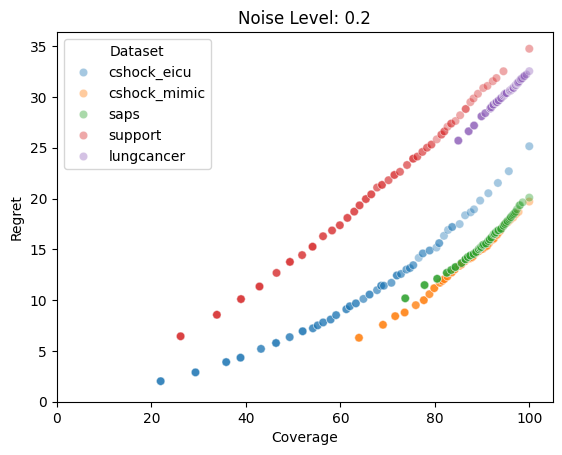

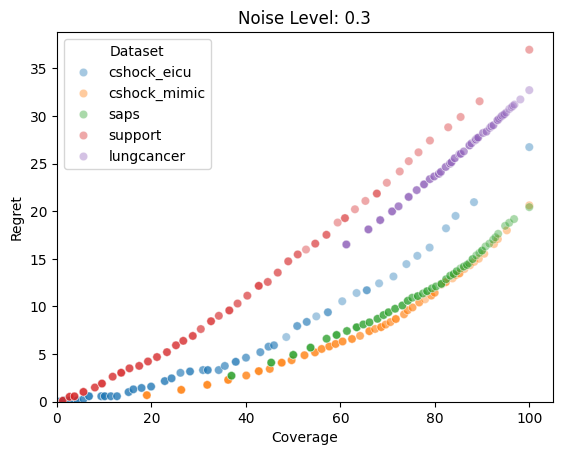

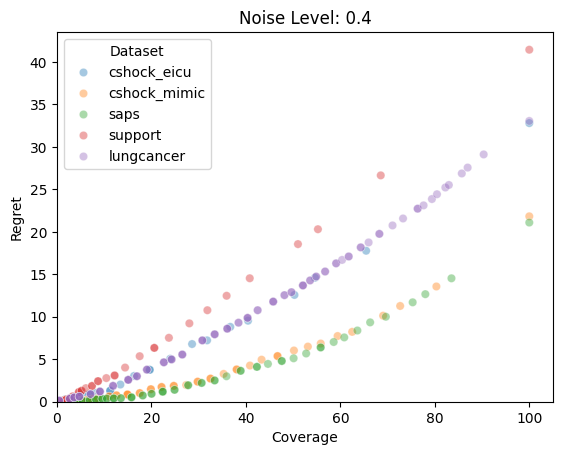

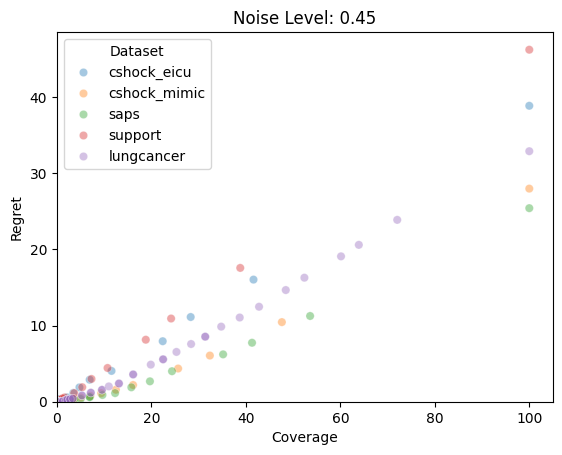

In [14]:
for noise_level in [0.1, 0.2, 0.3, 0.4, 0.45]:
    plt.figure()
    # Create the scatter plot
    sns.scatterplot(x='Coverage', y='Regret', hue="Dataset", data=data[(data["Noise Level"] == noise_level) & (data["Loss"] == "BCE")], alpha=0.4)
    
    # Set x-axis range from 0 to 100
    plt.xlim(0, 105)
    
    # Set y-axis minimum to 0
    plt.ylim(bottom=0)
    
    plt.title(f"Noise Level: {noise_level}")
    
    # Show the plot
    plt.show()


In [16]:
data[data["Noise Level"] == 0.45]

,Regret,Coverage,Noise Level,Threshold,Loss,Dataset
1200,0.000000,0.000000,0.45,0.000000,BCE,cshock_eicu
1201,0.000000,0.000000,0.45,1.020202,BCE,cshock_eicu
1202,0.000000,0.000000,0.45,2.040404,BCE,cshock_eicu
1203,0.000000,0.000000,0.45,3.060606,BCE,cshock_eicu
1204,0.000000,0.000000,0.45,4.080808,BCE,cshock_eicu
...,...,...,...,...,...,...
7495,16.385887,52.391926,0.45,96.919192,forward,lungcancer
7496,19.437381,60.147807,0.45,97.939394,forward,lungcancer
7497,21.002861,63.914495,0.45,98.959596,forward,lungcancer
7498,23.982835,72.043865,0.45,99.979798,forward,lungcancer
